<a href="https://colab.research.google.com/github/sharma-himanshukumar/LLM_Learning/blob/main/Model_buidling_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
!pip install -q transformers
!pip install -q torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.4.4 which is incompatible.
  Preparing metadata (setup.py) ... done


In [ ]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports from Third-party
import spacy
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Local Application/Library Specific Imports
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mtech /Dissertation/data_output/raw_data_converted_without_fp.csv')
mask = data['status'] == 'completed'
data['label'] = mask.map({True: 1, False: 0})
data= data.fillna("")
nlp = spacy.load("en_core_sci_sm")

In [ ]:
df= data.copy()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def create_word_embedding(text):
    doc = nlp(text)
    return sum(token.vector for token in doc) / len(doc)

df["Disease_Embedding"] = df["diseases_updated"].apply(create_word_embedding)
df["drugs_Embedding"] = df["drugs_updated"].apply(create_word_embedding)

def create_sentence_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        embedding = model(**tokens).last_hidden_state.mean(dim=1).squeeze()
    return embedding

df["why_stopped_Embedding"] = df["why_stop_updated"].apply(create_sentence_embedding)
df["criteria_Embedding"] = df["criteria_updated"].apply(create_sentence_embedding)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
len(df["drugs_Embedding"][90]),len(df["Disease_Embedding"][909]),len(df["why_stopped_Embedding"][90]),len(df["criteria_Embedding"][90])

KeyError: 'drugs_Embedding'

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

In [ ]:
train_df.shape, val_df.shape

((10199, 19), (4372, 19))

In [ ]:
sentence_embedding_1_numpy = train_df["why_stopped_Embedding"].apply(np.array).values
sentence_embedding_2_numpy = train_df["criteria_Embedding"].apply(np.array).values

X_train_sentence_1 = torch.stack([torch.Tensor(embedding) for embedding in sentence_embedding_1_numpy])
X_train_sentence_2 = torch.stack([torch.Tensor(embedding) for embedding in sentence_embedding_2_numpy])


val_sentence_embedding_1_numpy = val_df["why_stopped_Embedding"].apply(np.array).values
val_sentence_embedding_2_numpy = val_df["criteria_Embedding"].apply(np.array).values

X_val_sentence_1 = torch.stack([torch.Tensor(embedding) for embedding in val_sentence_embedding_1_numpy])
X_val_sentence_2 = torch.stack([torch.Tensor(embedding) for embedding in val_sentence_embedding_2_numpy])


X_train_word_1 = torch.stack([torch.Tensor(arr) for arr in train_df["drugs_Embedding"].values])
X_train_word_2 = torch.stack([torch.Tensor(arr) for arr in train_df["Disease_Embedding"].values])

X_val_word_1 = torch.stack([torch.Tensor(arr) for arr in val_df["drugs_Embedding"].values])
X_val_word_2 = torch.stack([torch.Tensor(arr) for arr in val_df["Disease_Embedding"].values])


y_train = torch.tensor(train_df["label"].values)

y_val = torch.tensor(val_df["label"].values)

In [ ]:
concatenated_embeddings = []
for i in range(len(X_train_word_1)):
    concatenated = torch.cat([X_train_word_1[i], X_train_word_2[i], X_train_sentence_1[i], X_train_sentence_2[i]], dim=0)
    concatenated_embeddings.append(concatenated)

X_train_concatenated = torch.stack(concatenated_embeddings)

train_dataset = TensorDataset(X_train_concatenated, y_train)
batch_size = 16  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
concatenated_embeddings = []
for i in range(len(X_val_word_1)):
    concatenated = torch.cat([X_val_word_1[i], X_val_word_2[i], X_val_sentence_1[i], X_val_sentence_2[i]], dim=0)
    concatenated_embeddings.append(concatenated)


X_val_concatenated = torch.stack(concatenated_embeddings)

val_dataset = TensorDataset(X_val_concatenated, y_val)
batch_size = 16  # Choose an appropriate batch size
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
X_train_concatenated.shape, X_val_concatenated.shape

(torch.Size([10199, 1728]), torch.Size([4372, 1728]))

In [ ]:
class EnhancedModel_hyper(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(EnhancedModel_hyper, self).__init__()

        self.fc_layers = nn.ModuleList()

        # Input layer first
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers (Dense layer)
        for i in range(1, len(hidden_sizes)):
            self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.fc_layers.append(nn.Dropout(dropout_prob))
        # Output layer end
        self.output_fc = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, combined_embedding):
        # Pass through fully connected layers
        for fc_layer in self.fc_layers:
            combined_embedding = torch.relu(fc_layer(combined_embedding))

        # Output layer (single value for binary classification)
        output = torch.sigmoid(self.output_fc(combined_embedding))  # Sigmoid activation for binary classification

        return output

In [ ]:
input_size = X_train_concatenated.shape[1]
hidden_size = [512, 256, 128, 64]
num_classes = 1
batch_size = 16
learning_rate = 0.001
num_epochs = 10

model = EnhancedModel_hyper(input_size, hidden_size, num_classes)

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)

        labels = labels.float()
        # Calculate the loss
        loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels if needed

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {average_loss:.4f}")

print("Training finished.")

Epoch [1/10] | Loss: 0.2819
Epoch [2/10] | Loss: 0.2519
Epoch [3/10] | Loss: 0.2447
Epoch [4/10] | Loss: 0.2394
Epoch [5/10] | Loss: 0.2355
Epoch [6/10] | Loss: 0.2368
Epoch [7/10] | Loss: 0.2348
Epoch [8/10] | Loss: 0.2302
Epoch [9/10] | Loss: 0.2330
Epoch [10/10] | Loss: 0.2355
Training finished.


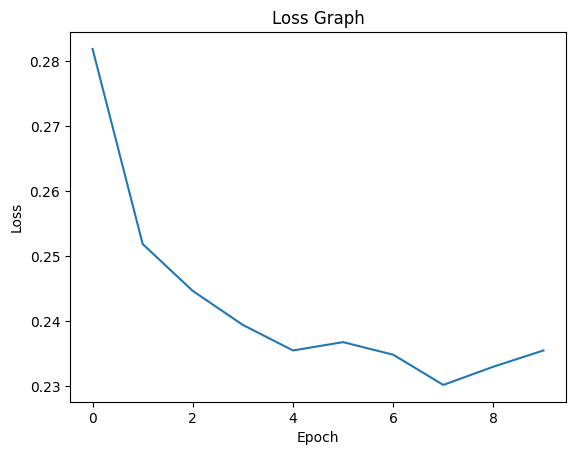

In [ ]:
plt.plot(losses)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Forward pass
        outputs = model(inputs)

        labels = labels.float()  # Convert to FloatTensor

        # Threshold outputs to get binary predictions (0 or 1)
        predictions = (outputs >= 0.6).float()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[ 991  297]
 [   0 3084]]
Accuracy: 0.9321
Precision: 0.9122
Recall: 1.0000


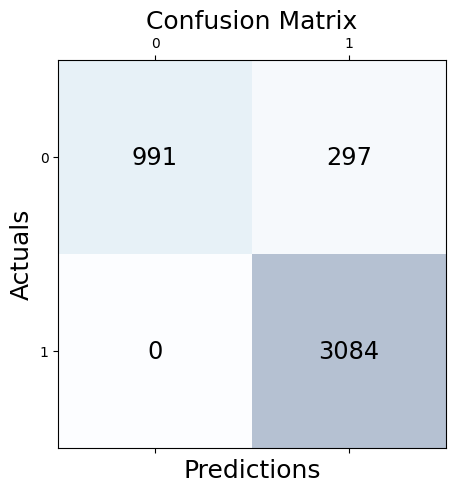

In [ ]:
fig, ax = plt.subplots(figsize=(5, 15))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
tn, fp, fn, tp = conf_matrix.ravel()

print("True Positive (TP): ", tp)
print("True Negative (TN): ", tn)
print("False Positive (FP): ", fp)
print("False Negative (FN): ", fn)


accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the formulas for accuracy, precision, recall, and F1-score
print("\n\nFormulas:")
print("Accuracy: (TP + TN) / (TP + TN + FP + FN)")
print("Precision: TP / (TP + FP)")
print("Recall: TP / (TP + FN)")
print("F1-score: 2 * (Precision * Recall) / (Precision + Recall)")

# Print the accuracy, precision, recall, and F1-score
print("\n\nMetrics:")
print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1-score: ", round(f1_score, 2))

True Positive (TP):  3084
True Negative (TN):  991
False Positive (FP):  297
False Negative (FN):  0


Formulas:
Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)


Metrics:
Accuracy:  0.93
Precision:  0.91
Recall:  1.0
F1-score:  0.95


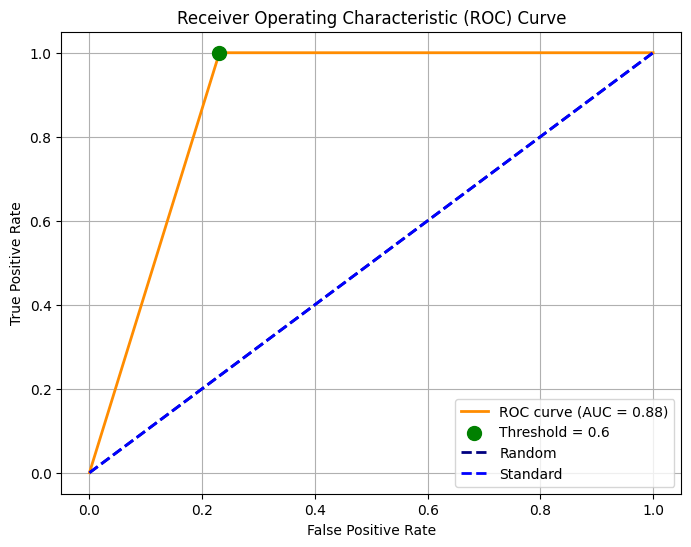

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

highlight_threshold = 0.6
highlight_index = np.argmin(np.abs(thresholds - highlight_threshold))

roc_auc = auc(fpr, tpr)

# Plot the ROC curve with standard line in blue and AUC for our model in green
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})', linestyle='-')
plt.scatter(fpr[highlight_index], tpr[highlight_index], color='green', s=100, label=f'Threshold = {highlight_threshold}', zorder=5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Standard')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


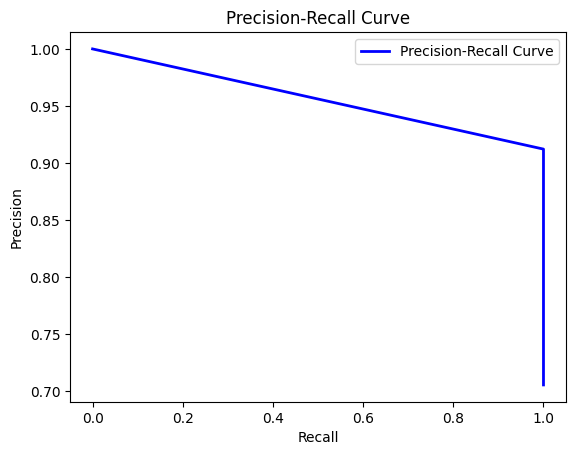

In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

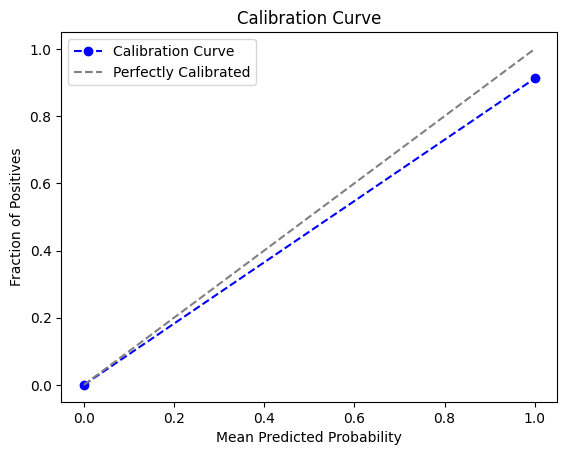

In [ ]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_labels, n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color='blue', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.show()

#### ---------------------------------------------------------------------------- End-------------------------------------------------------------------------